In [1]:
import numpy as np

In [2]:
import numpy as np
import tensorflow as tf

def is_nan_list(lst):
    # Check if the list has one element and that element is NaN
    return len(lst) == 1 and np.isnan(lst[0])

def flatten_landmarks(landmark_list):
    """
    Flattens a list of dictionaries with x, y, z coordinates into a single flat list.

    Parameters:
    - landmark_list (list): A list of dictionaries, each containing a 'landmark' dictionary with 'x', 'y', 'z'.

    Returns:
    - flat_list (list): A flattened list of all x, y, and z values from the landmark dictionaries.
    """
    # Check for NaN list condition
    if isinstance(landmark_list, list) and len(landmark_list) == 1 and np.isnan(landmark_list[0]):
        return [0] * 63  # Return a list of zeros if landmarks are missing

    # Flatten the list using list comprehension
    flat_list = [coord for landmark in landmark_list for coord in landmark['landmark'].values()]

    return flat_list

def prepare_lstm_data(data):
    """
    Converts a 2D numpy array into input tensors for LSTM training.

    Parameters:
    - data (numpy array): 2D array where each row is [label, right_landmarks, left_landmarks]
      `right_landmarks` and `left_landmarks` are lists containing 21 dictionaries each, with x, y, z coordinates, or [nan] if missing.

    represent data for each time step as a flat 126 element array (21 * 3 * 2).
    i landmarks, let xri be the x coordinate for the ith landmark for the right hand, xli then [xr1, yr1, zr1.... xr26, yr26, zr26, xl1, yl1, zl1, ....  xl26, yl26, zl26] is the data
    For each label (2d: (num_timesteps, data_per_timestep))

    Returns:
    - X (numpy array): Input features for LSTM (sequences of landmarks)
    - y (numpy array): Labels for each sequence
    """
    n_samples = data.shape[0]
    n_landmarks = 21  # Assuming 21 landmarks per hand
    n_coordinates = 3  # x, y, and z coordinates

    # Prepare arrays for inputs and labels
    # Assuming each sequence can vary in length, we will use a list to collect them
    X = []
    y = []

    for i in range(n_samples):
      right_hand = data[i, 1]  # Right hand landmarks
      left_hand = data[i, 2]  # Left hand landmarks

      seq_len = 21
      seq_landmarks = []
      if right_hand is not None and left_hand is not None:
        for sequence_id in range(len(right_hand)):
          right_seq = right_hand[sequence_id]["landmark_list"]
          left_seq = left_hand[sequence_id]["landmark_list"]
          if is_nan_list(right_seq) and is_nan_list(left_seq):
            continue
          right_landmarks = flatten_landmarks(right_seq)
          left_landmarks = flatten_landmarks(left_seq)
          landmarks = right_landmarks + left_landmarks
          seq_landmarks.append(landmarks)

        # Concatenate right and left hand landmark data
        X.append(seq_landmarks)
        y.append(data[i, 0])

    # Convert list to numpy array for LSTM processing, handling variable sequence lengths appropriately if necessary
    X = np.array(X, dtype=object)  # Use dtype=object for variable-length sequences
    y = np.array(y)
    return X, y

In [3]:
import os

root = "/content/drive/MyDrive/IEEE ML/Data"

X, y = np.array([]), np.array([])

for root, dirs, files in os.walk(root):
    for i, file in enumerate(files):
        # if "yt" == file[:2]:
        fname = os.path.join(root, file)
        print(f"{i+1} now processing {file}")
        data = np.load(fname, allow_pickle=True)
        curr_X, curr_y = prepare_lstm_data(data)
        X = np.append(X, curr_X)
        y = np.append(y, curr_y)

print(len(X))
print(len(y))


1 now processing asllvd-1-0.npy
2 now processing asllvd-4-0.npy
3 now processing asllvd-5-0.npy
4 now processing asllvd-2-0.npy
5 now processing asllvd-7-0.npy
6 now processing asllvd-6-0.npy
7 now processing asllvd-3-0.npy
8 now processing asllvd-6-1.npy
9 now processing asllvd-0-1.npy
10 now processing asllvd-5-1.npy
11 now processing asllvd-4-1.npy
12 now processing asllvd-1-1.npy
13 now processing asllvd-7-1.npy
14 now processing asllvd-3-1.npy
15 now processing asllvd-2-1.npy
16 now processing no_yt-0-0.npy
17 now processing no_yt-3-0.npy
18 now processing no_yt-4-0.npy
19 now processing no_yt-5-0.npy
20 now processing no_yt-6-0.npy
21 now processing no_yt-7-0.npy
22 now processing no_yt-2-0.npy
23 now processing no_yt-1-0.npy
24 now processing no_yt-3-1.npy
25 now processing no_yt-6-1.npy
26 now processing no_yt-2-1.npy
27 now processing no_yt-0-1.npy
28 now processing no_yt-5-1.npy
29 now processing no_yt-1-1.npy
30 now processing no_yt-4-1.npy
31 now processing no_yt-7-1.npy
32

In [4]:
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

def create_padded_sequences(X):
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq in X]
  X_padded = pad_sequence(sequences, batch_first=True, padding_value=0.0)
  return X_padded

def create_one_hot_y(Y):
  y = torch.tensor(Y)
  num_classes = torch.max(y) + 1
  y_one_hot = F.one_hot(y, num_classes=num_classes)
  return y_one_hot

In [5]:
def create_vocab(y):
  """
  create and return to vocab to id mappings - bidirectional
  """
  vocab_to_id = {}
  id_to_vocab = []
  count = 0
  for id, label in enumerate(y):
    if label in vocab_to_id:
      continue
    vocab_to_id[label] = count
    id_to_vocab.append(label)
    count+=1
  return vocab_to_id, id_to_vocab

def create_Y(y, vocab_to_id):
  return [vocab_to_id[label] for label in y]

In [ ]:
#['TWENTY', 'ALONE', 'BACHELOR', 'ALWAYS', 'ONE']
#output = [0.5, 0.2, 0.1, 0.1, 0.1], pred = 0
#actual = 3, [0,0,0,1,0] #one-hot encoding

In [6]:
keep = []
for id, example in enumerate(X):
  if len(example) == 0:
    continue
  keep.append(id)

X, y = X[keep], y[keep]
print(f"length X: {len(X)}, length Y: {len(y)}")

length X: 44100, length Y: 44100


In [7]:
vocab_to_id, id_to_vocab = create_vocab(y)
Y = create_Y(y, vocab_to_id)
Y = torch.tensor(Y)

In [8]:
print(len(Y))

len(id_to_vocab)

44100


4943

In [9]:
import json

with open('vocab.json', 'w+') as file:
    json.dump(vocab_to_id, file)

In [10]:
X_padded = create_padded_sequences(X)


In [11]:
import torch
import torch.nn as nn

class MultiLayerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=3, dropout_rate=0):
        super(MultiLayerLSTM, self).__init__()
        # Initialize the LSTM layer with multiple layers and optionally add dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout_rate, bidirectional=True)
        # A dropout layer for some regularization
        self.dropout = nn.Dropout(dropout_rate)
        # A fully connected layer for the output
        self.classifier = nn.Linear(2 * hidden_size, num_classes)

    def forward(self, x):
        # Pass data through the LSTM
        # The output of this function are all hidden states at the last layer, hidden state, and the cell state at last time step
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Apply dropout to the final hidden state
        last_hidden_state = self.dropout(torch.cat((h_n[-2], h_n[-1]), dim=1))  # Concatenate the last states of both directions
        # Fully connected layer to transform to class prediction space
        out = self.classifier(last_hidden_state)
        return out


In [19]:
# Parameters
input_size = 126  # Number of input features (e.g., concatenated landmark features)
hidden_size = 128  # Number of features in the hidden state
num_classes = len(vocab_to_id)
num_layers = 4  # Number of stacked LSTM layers
dropout_rate = 0.15 # Dropout rate

# Initialize the model
model = MultiLayerLSTM(input_size, hidden_size, num_classes, num_layers, dropout_rate)

# Print the model architecture
print(model)

MultiLayerLSTM(
  (lstm): LSTM(126, 128, num_layers=4, batch_first=True, dropout=0.15, bidirectional=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (classifier): Linear(in_features=256, out_features=4943, bias=True)
)


In [13]:
train, valid = int(len(X_padded) * 0.8), int(len(X_padded) * 0.1)

X_train, Y_train = X_padded[:train], Y[:train]
X_valid, Y_valid = X_padded[train:train+valid], Y[train:train+valid]
X_test, Y_test = X_padded[train+valid:], Y[train+valid:]

In [14]:
print(f"num points = train: {len(X_train)}, valid: {len(X_valid)}, test: {len(X_test)}")
print(f"num labels = train: {len(Y_train)}, valid: {len(Y_valid)}, test: {len(Y_test)}")

num points = train: 35280, valid: 4410, test: 4410
num labels = train: 35280, valid: 4410, test: 4410


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model.to(device)

X_train, Y_train = X_train.to(device), Y_train.to(device)
X_valid, Y_valid = X_valid.to(device), Y_valid.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)



In [17]:
from torch.utils.data import DataLoader, TensorDataset

# Create datasets
train_dataset = TensorDataset(X_train, Y_train)
valid_dataset = TensorDataset(X_valid, Y_valid)
test_dataset = TensorDataset(X_test, Y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [21]:
criterion = torch.nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
num_epochs = 40

train_losses = []
valid_losses = []

best_loss = float("inf")
best_state_dict = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)

    if epoch >= 25:
      if valid_loss < best_loss:
        print(f"Epoch {epoch+1}: Saving Checkpoint")
        best_state_dict, best_loss = model.state_dict(), valid_loss


    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Valid Loss = {valid_loss:.4f}")


Epoch 1: Train Loss = 8.1398, Valid Loss = 7.3317
Epoch 2: Train Loss = 7.6029, Valid Loss = 7.1129
Epoch 3: Train Loss = 7.3543, Valid Loss = 7.0269
Epoch 4: Train Loss = 7.1559, Valid Loss = 6.8635
Epoch 5: Train Loss = 6.9744, Valid Loss = 6.7207
Epoch 6: Train Loss = 6.8414, Valid Loss = 6.6807
Epoch 7: Train Loss = 6.6555, Valid Loss = 6.5321
Epoch 8: Train Loss = 6.4544, Valid Loss = 6.4596
Epoch 9: Train Loss = 6.3204, Valid Loss = 6.4507
Epoch 10: Train Loss = 6.1823, Valid Loss = 6.3306
Epoch 11: Train Loss = 6.0513, Valid Loss = 6.2609
Epoch 12: Train Loss = 5.9122, Valid Loss = 6.2155
Epoch 13: Train Loss = 5.8008, Valid Loss = 6.1745
Epoch 14: Train Loss = 5.7097, Valid Loss = 6.1227
Epoch 15: Train Loss = 5.5814, Valid Loss = 6.0823
Epoch 16: Train Loss = 5.4990, Valid Loss = 6.0888
Epoch 17: Train Loss = 5.3781, Valid Loss = 5.9865
Epoch 18: Train Loss = 5.3371, Valid Loss = 5.9586
Epoch 19: Train Loss = 5.1666, Valid Loss = 5.9369
Epoch 20: Train Loss = 5.1149, Valid Los

In [35]:
torch.save(best_state_dict, "model_state_dict.pth")

In [24]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, valid_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f'Training Loss')
    plt.plot(valid_losses, label=f'Validation Loss')
    plt.title(f'Loss Curves: {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

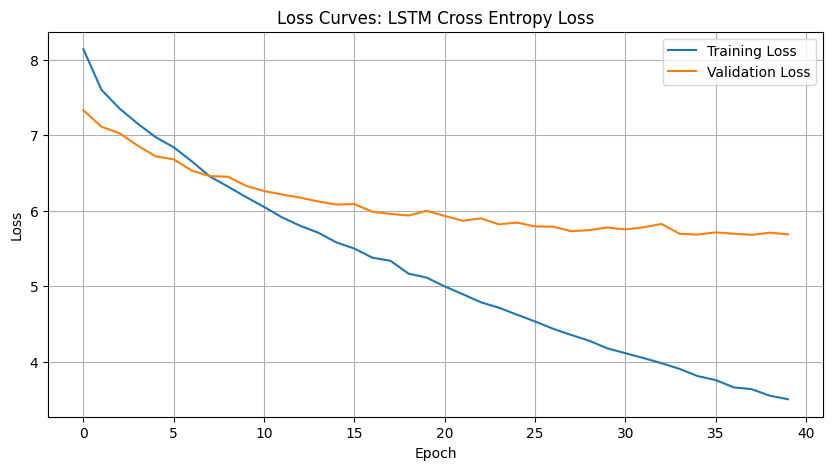

In [25]:
plot_loss_curves(train_losses, valid_losses, "LSTM Cross Entropy Loss")

In [22]:
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 6.0610


In [26]:
import numpy as np
import torch
import torch.nn.functional as F

def predict_from_numpy(model, example, id_to_vocab):
    """
    Takes a PyTorch model and a NumPy array containing a single example, converts it to a tensor,
    runs the model to predict logit scores, applies softmax, and returns the predicted class index.

    Args:
    - model (torch.nn.Module): The trained PyTorch model.
    - input: list containing the media pipe features

    Returns:
    - int: The index of the highest probability class.
    """
    model.eval()

    # Convert the NumPy array to a PyTorch tensor
    input_tensor = torch.tensor(example).float()  # Ensure it's a float tensor for most models

    # Add a batch dimension using unsqueeze if necessary
    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)

    probabilities = F.softmax(logits, dim=1)

    _, predicted_index = torch.max(probabilities, dim=1)

    return id_to_vocab[predicted_index.item()]


In [28]:
# Parameters
input_size = 126  # Number of input features (e.g., concatenated landmark features)
hidden_size = 128  # Number of features in the hidden state
num_classes = len(vocab_to_id)
num_layers = 3  # Number of stacked LSTM layers
dropout_rate = 0.15 # Dropout rate

# Initialize the model
model = MultiLayerLSTM(input_size, hidden_size, num_classes, num_layers, dropout_rate)

# Print the model architecture
print(model)

state_dict = torch.load('model_state_dict.pth')
model.load_state_dict(state_dict)

MultiLayerLSTM(
  (lstm): LSTM(126, 128, num_layers=3, batch_first=True, dropout=0.15, bidirectional=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (classifier): Linear(in_features=256, out_features=4943, bias=True)
)


FileNotFoundError: [Errno 2] No such file or directory: 'model_state_dict.pth'

In [29]:
model.to(torch.device("cpu"))

MultiLayerLSTM(
  (lstm): LSTM(126, 128, num_layers=3, batch_first=True, dropout=0.15, bidirectional=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (classifier): Linear(in_features=256, out_features=4943, bias=True)
)

In [34]:
i = 1
actual = y[i]
pred = predict_from_numpy(model, [X[i]], id_to_vocab)
print(f"actual sign: {actual}, predicted sign: {pred}")

actual sign: ALONE, predicted sign: hamburger
